INTERFERENCE SYSTEM I - pm10, pm2.5 -> pollution

DATA SOURCES
https://powietrze.gios.gov.pl/pjp/current/station_details/archive/402
http://meteo.kdwd.webd.pl/wxhistory.php?date=202310

In [433]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skfuzzy import control as ctrl
from distfit import distfit

In [434]:
pm10_safe_limit = 50 # per 1h -> ug/m3
pm25_safe_limit = 25 # per 1h -> ug/m3

In [435]:
column_names = ["Date Time", "PM10", "PM25"]
df = pd.read_csv("gios-pjp-data.csv", sep=",", skiprows=1, header=None)
df = df.iloc[:, :-4]
df.columns = column_names
df["Date Time"] = pd.to_datetime(df["Date Time"], format="%Y-%m-%d %H:%M")
df["PM10"] = df["PM10"].astype(float)
df["PM25"] = df["PM25"].astype(float)
df = df.drop(df.tail(1).index)
df.head()

Date Time  PM10  PM25
0 2023-10-01 01:00:00  18.9  25.8
1 2023-10-01 02:00:00  18.9  25.2
2 2023-10-01 03:00:00  19.2  25.3
3 2023-10-01 04:00:00  21.9  28.5
4 2023-10-01 05:00:00  21.0  25.5

In [436]:
column_names_wind = ["Date", "Wind"]
df_wind = pd.read_csv("wind.csv", sep=",", header=None)
df_wind = df_wind.iloc[:, :-1]
df_wind.columns = column_names_wind
df_wind["Date"] = pd.to_datetime(df_wind["Date"], format="%d.%m.%Y")
df_wind["Wind"] = df_wind["Wind"].astype(float)
df_wind.head()

Date  Wind
0 2023-10-01   1.2
1 2023-10-02   1.5
2 2023-10-03   2.8
3 2024-10-04   4.5
4 2024-10-05   3.1

In [437]:
dataframes = []

for index, row in df_wind.iterrows():
    for hour in range(24):
        new_date_time = row["Date"] + pd.DateOffset(hours=hour)
        dataframes.append(pd.DataFrame({"Date Time": [new_date_time], "Wind": [row["Wind"]]}))

df_hourly_wind = pd.concat(dataframes)

column_hourly_wind = ["Date Time", "Wind"]
df_hourly_wind.columns = column_hourly_wind

df_hourly_wind["Date Time"] = pd.to_datetime(df_hourly_wind["Date Time"], format="%Y-%m-%d %H:%M")
df_hourly_wind["Wind"] = df_hourly_wind["Wind"].astype(float)

df_hourly_wind = df_hourly_wind.reset_index(drop=True)

df_hourly_wind.drop(df_hourly_wind.head(1).index, inplace=True)

df_hourly_wind.head()

Date Time  Wind
1 2023-10-01 01:00:00   1.2
2 2023-10-01 02:00:00   1.2
3 2023-10-01 03:00:00   1.2
4 2023-10-01 04:00:00   1.2
5 2023-10-01 05:00:00   1.2

In [438]:
df = df.join(df_hourly_wind, lsuffix="_df", rsuffix="_df_hourly_wind")
df.drop("Date Time_df_hourly_wind", axis=1, inplace=True)
df.describe()

Date Time_df        PM10        PM25        Wind
count                            743  743.000000  743.000000  742.000000
mean   2023-10-16 12:00:00.000000256   18.842665   27.137550    2.995013
min              2023-10-01 01:00:00    1.000000    1.000000    0.900000
25%              2023-10-08 18:30:00    9.700000   14.700000    1.900000
50%              2023-10-16 12:00:00   16.600000   22.600000    2.800000
75%              2023-10-24 05:30:00   24.000000   34.900000    4.000000
max              2023-10-31 23:00:00   74.600000  270.900000    6.900000
std                              NaN   11.871502   19.279612    1.423616

In [439]:
pm10_max = df["PM10"].max()
pm25_max = df["PM25"].max()
wind_max = df["Wind"].max()

pm10_min = df["PM10"].min()
pm25_min = df["PM25"].min()
wind_min = df["Wind"].min()

In [440]:
step_size = 0.01

In [441]:
good = "good"
moderate = "moderate"
unhealthy = "unhealthy"

[1.0, 50, 74.6]
50 1.0 74.6 74.6


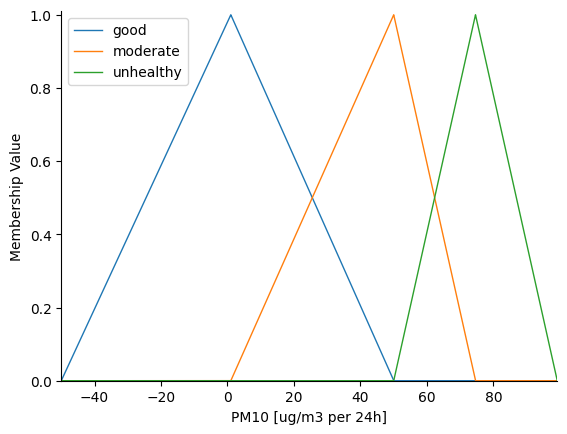

In [442]:
pm10_list = [pm10_min, pm10_safe_limit, pm10_max]
pm10_list.sort()
print(pm10_list)

pm10 = ctrl.Antecedent(np.arange(-pm10_list[1], pm10_list[2] + (pm10_list[2] - pm10_list[1]) + step_size, step_size), "pm10")
pm10[good] = fuzz.trimf(pm10.universe, [-pm10_list[1], pm10_list[0], pm10_list[1]])
pm10[moderate] = fuzz.trimf(pm10.universe, [pm10_list[0], pm10_list[1], pm10_list[2]])
pm10[unhealthy] = fuzz.trimf(pm10.universe, [pm10_list[1], pm10_list[2], pm10_list[2] + (pm10_list[2] - pm10_list[1])])
pm10.view()

print(pm10_safe_limit, pm10_min, pm10_max, pm10_max)

plt.xlabel("PM10 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

In [443]:
good = "good"
moderate = "moderate"
unhealthy = "unhealthy"

[1.0, 25, 270.9]


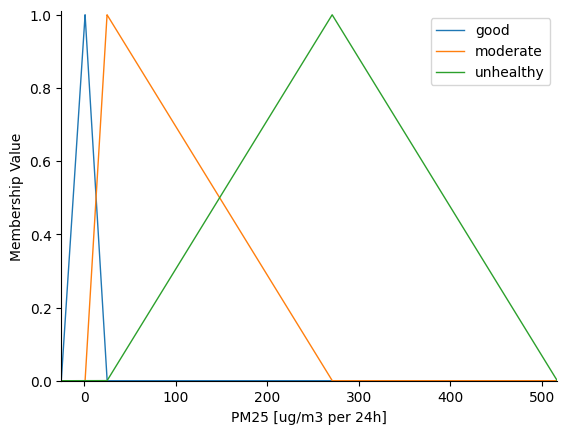

In [444]:
pm25_list = [pm25_min, pm25_safe_limit, pm25_max]
pm25_list.sort()
print(pm25_list)

pm25 = ctrl.Antecedent(np.arange(-pm25_list[1], pm25_list[2] + (pm25_list[2] - pm25_list[1]) + step_size, step_size), "pm25")
pm25[good] = fuzz.trimf(pm25.universe, [-pm25_list[1], pm25_list[0], pm25_list[1]])
pm25[moderate] = fuzz.trimf(pm25.universe, [pm25_list[0], pm25_list[1], pm25_list[2]])
pm25[unhealthy] = fuzz.trimf(pm25.universe, [pm25_list[1], pm25_list[2], pm25_list[2] + (pm25_list[2] - pm25_list[1])])
pm25.view()

plt.xlabel("PM25 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

In [445]:
air_quality_poor = 0
air_quality_bad = 25
air_quality_normal =  50
air_quality_good = 75
air_quality_excelent = 100

In [446]:
pollution_minimal = "pollution_minimal"
pollution_low = "pollution_low"
pollution_normal = "pollution_normal"
pollution_high = "pollution_high"
pollution_maximum = "pollution_maximum"

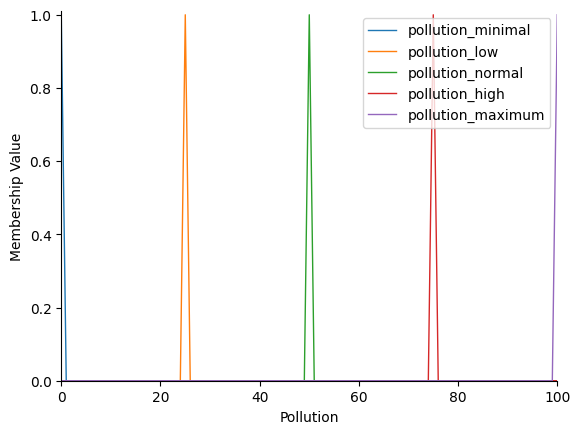

In [447]:
pollution = ctrl.Consequent(np.arange(0, 101, 1), "pollution", defuzzify_method="centroid")
pollution[pollution_minimal] = fuzz.trimf(pollution.universe, [0, 0, 0])
pollution[pollution_low] = fuzz.trimf(pollution.universe, [25, 25, 25])
pollution[pollution_normal] = fuzz.trimf(pollution.universe, [50, 50, 50])
pollution[pollution_high] = fuzz.trimf(pollution.universe, [75, 75, 75])
pollution[pollution_maximum] = fuzz.trimf(pollution.universe, [100, 100, 100])
pollution.view()

plt.xlabel("Pollution")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

In [448]:
rule1 = ctrl.Rule(pm10[unhealthy] & pm25[unhealthy],  pollution[pollution_maximum])

rule2 = ctrl.Rule(pm10[good] & pm25[unhealthy],  pollution[pollution_high])
rule3 = ctrl.Rule(pm10[moderate] & pm25[unhealthy],  pollution[pollution_maximum])
rule4 = ctrl.Rule(pm10[unhealthy] & pm25[good],  pollution[pollution_high])
rule5 = ctrl.Rule(pm10[unhealthy] & pm25[moderate],  pollution[pollution_maximum])

rule6 = ctrl.Rule(pm10[good] & pm25[good],  pollution[pollution_minimal])
rule7 = ctrl.Rule(pm10[good] & pm25[moderate],  pollution[pollution_low])
rule8 = ctrl.Rule(pm10[moderate] & pm25[good],  pollution[pollution_low])
rule9 = ctrl.Rule(pm10[moderate] & pm25[moderate],  pollution[pollution_normal])

In [449]:
pollution_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
pollution_sim = ctrl.ControlSystemSimulation(pollution_ctrl)

In [450]:
num_of_points = 40
pm10_values = np.linspace(pm10_min, pm10_max, num_of_points)
pm25_values = np.linspace(pm25_min, pm25_max, num_of_points)
pm10_mesh, pm25_mesh= np.meshgrid(pm10_values, pm25_values)
pollution_values = np.zeros_like(pm10_mesh)

In [451]:
def compute(defuzzify_method):
    pollution.defuzzify_method = defuzzify_method
    for i in range(len(pm10_values)):
        for j in range(len(pm25_values)):
            pollution_sim.input["pm10"] = pm10_values[i]
            pollution_sim.input["pm25"] = pm25_values[j]
            pollution_sim.compute()
            pollution_values[i, j] = pollution_sim.output["pollution"]

In [452]:
def display_3d_plot_pm_single(xlabel, ylabel, zlabel, azim):
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(pm10_mesh, pm25_mesh, pollution_values, cmap="RdYlGn_r")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    ax.view_init(azim=azim)

    plt.show()

def display_3d_plot_pm(ax, xlabel, ylabel, zlabel, azim):
    ax.plot_surface(pm10_mesh, pm25_mesh, pollution_values, cmap="RdYlGn_r")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.view_init(azim=azim)

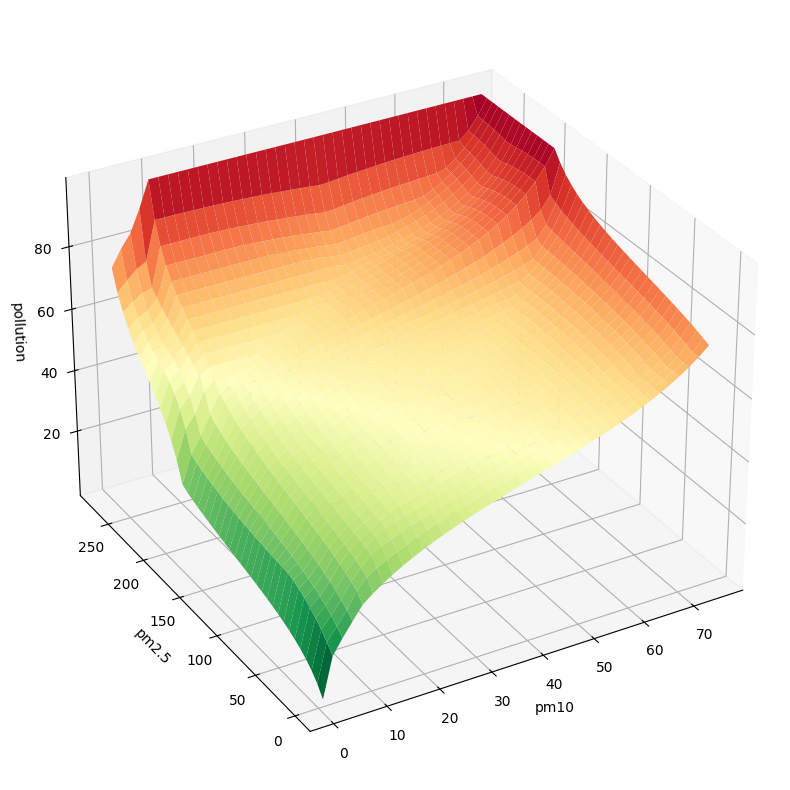

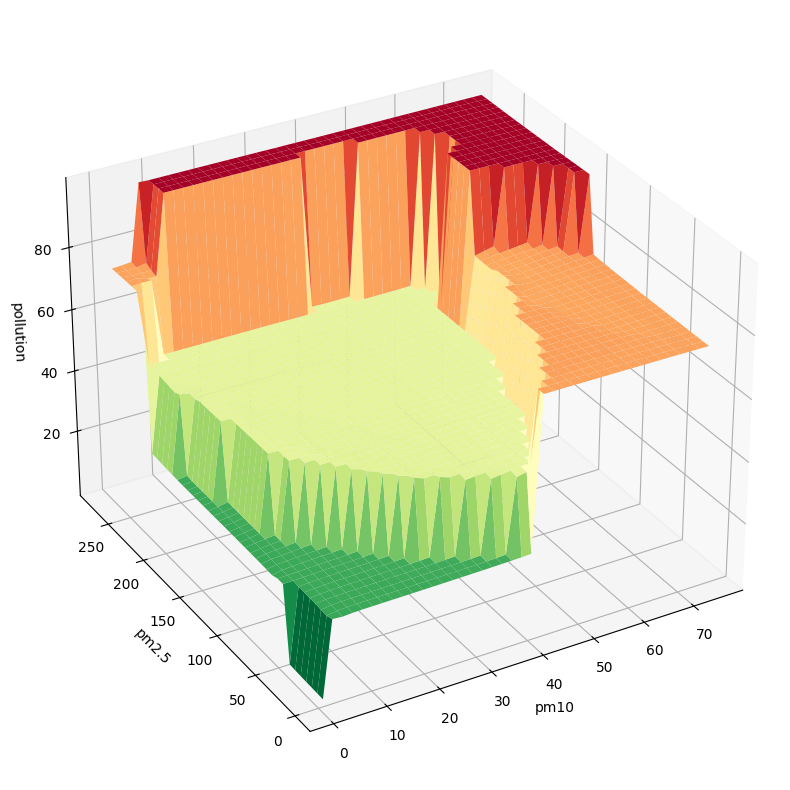

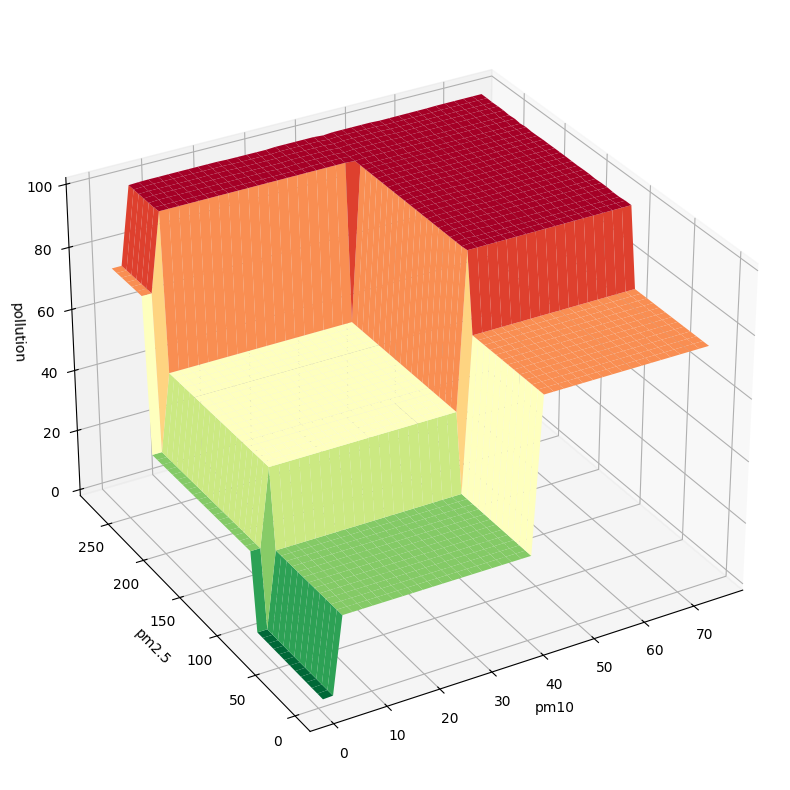

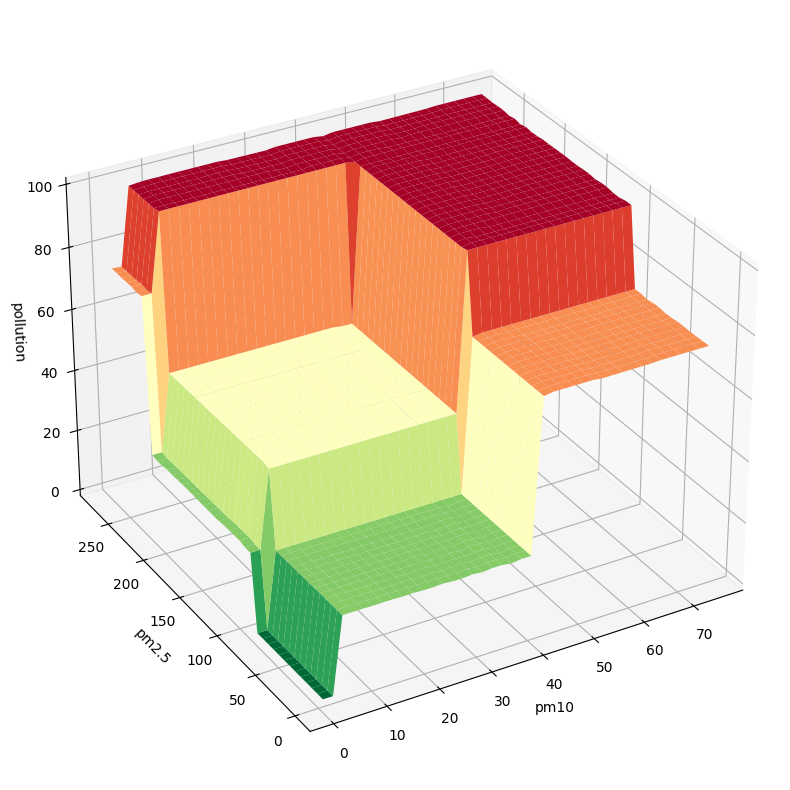

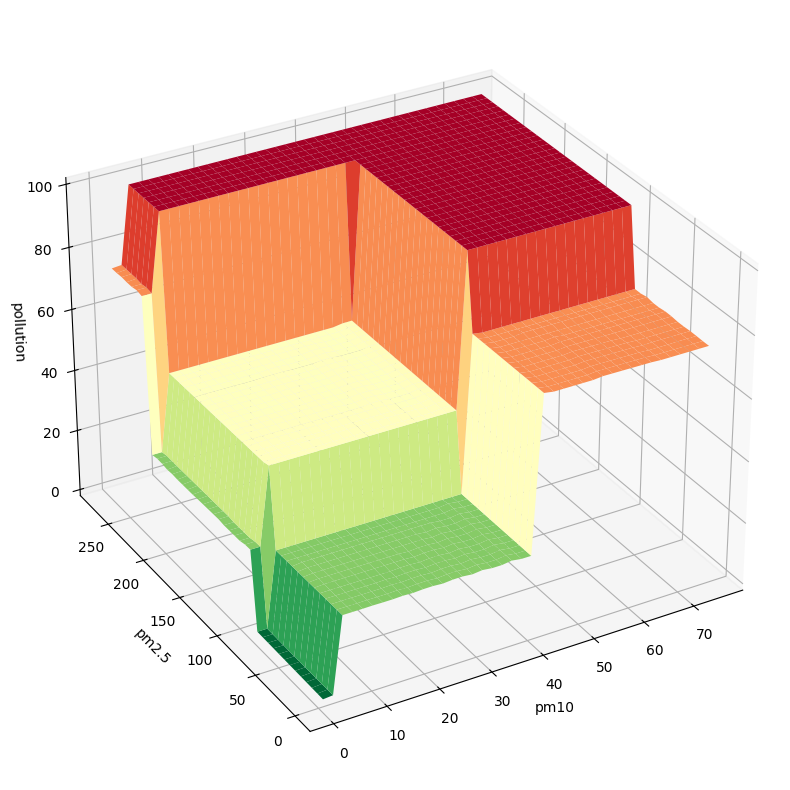

In [453]:
compute("centroid")
display_3d_plot_pm_single("pm10", "pm2.5", "pollution", -120)

compute("bisector")
display_3d_plot_pm_single("pm10", "pm2.5", "pollution",  -120)

compute("mom")
display_3d_plot_pm_single("pm10", "pm2.5", "pollution",  -120)

compute("som")
display_3d_plot_pm_single("pm10", "pm2.5", "pollution",  -120)

compute("lom")
display_3d_plot_pm_single("pm10", "pm2.5", "pollution",  -120)

In [454]:
# fig, axs = plt.subplots(2, 3, figsize=(15, 15), subplot_kw={"projection": "3d"})
# methods = ["centroid", "bisector", "mom", "som", "lom"]

# for i, method in enumerate(methods):
#     row, col = divmod(i, 3)
#     ax = axs[row, col]
#     compute(method)
#     display_3d_plot_pm(ax, "pm10", "pm2.5", "pollution", 60)
# plt.tight_layout()

# plt.show()

INTERFERENCE SYSTEM II - pollution, wind -> air_quality

In [455]:
pollution_values = []

In [456]:
def compute_real(defuzzify_method):
    pollution.defuzzify_method = defuzzify_method
    for i in range(len(df)):
        pollution_sim.input["pm10"] = df.iloc[i, 1]
        pollution_sim.input["pm25"] = df.iloc[i, 2]
        pollution_sim.compute()
        pollution_values.append(pollution_sim.output["pollution"])

In [457]:
# create df
compute_real("centroid")

data = {"Pollution": pollution_values, "Wind": df_hourly_wind["Wind"].to_list()}
df_pollution_wind = pd.DataFrame(data)

In [458]:
df_pollution_wind.head()

Pollution  Wind
0  35.516668   1.2
1  35.279248   1.2
2  35.427884   1.2
3  37.564911   1.2
4  36.145181   1.2

In [459]:
df_pollution_wind.describe()

Pollution        Wind
count  743.000000  743.000000
mean    33.466112    2.999192
std     10.932075    1.427209
min      0.333333    0.900000
25%     24.893603    1.900000
50%     32.075439    2.800000
75%     40.278956    4.000000
max     99.666667    6.900000

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.000437194] [loc=33.466 scale=10.925]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00564565] [loc=0.333 scale=33.133]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.00564565] [loc=-2147483647.667 scale=2147483648.000]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 0.000300814] [loc=32.686 scale=9.674]
[distfit] >INFO> [t         ] [0.17 sec] [RSS: 0.000444425] [loc=33.335 scale=10.617]
[distfit] >INFO> [genextreme] [0.09 sec] [RSS: 0.000214846] [loc=28.805 scale=9.807]
[distfit] >INFO> [gamma     ] [0.01 sec] [RSS: 0.000260227] [loc=-16.177 scale=2.377]
[distfit] >INFO> [lognorm   ] [0.0 sec] [RSS: 0.000256627] [loc=-33.544 scale=66.141]
[distfit] >INFO> [beta      ] [0.07 sec] [RSS: 0.000257183] [loc=-15.301 scale=6996263.649]
[distfit] >INFO> [uniform   ] [0.0 sec] [RSS: 0.00511459] [loc=0.333 scale=99.333]
[distfit] >INFO> [loggamma  ] [0.03 sec] [RSS: 0.000445354] [loc=-4024.795 sc

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\ngenextreme(c=0.103843, loc=28.8055, scale=9.80705)'}, xlabel='Values', ylabel='Frequency'>)

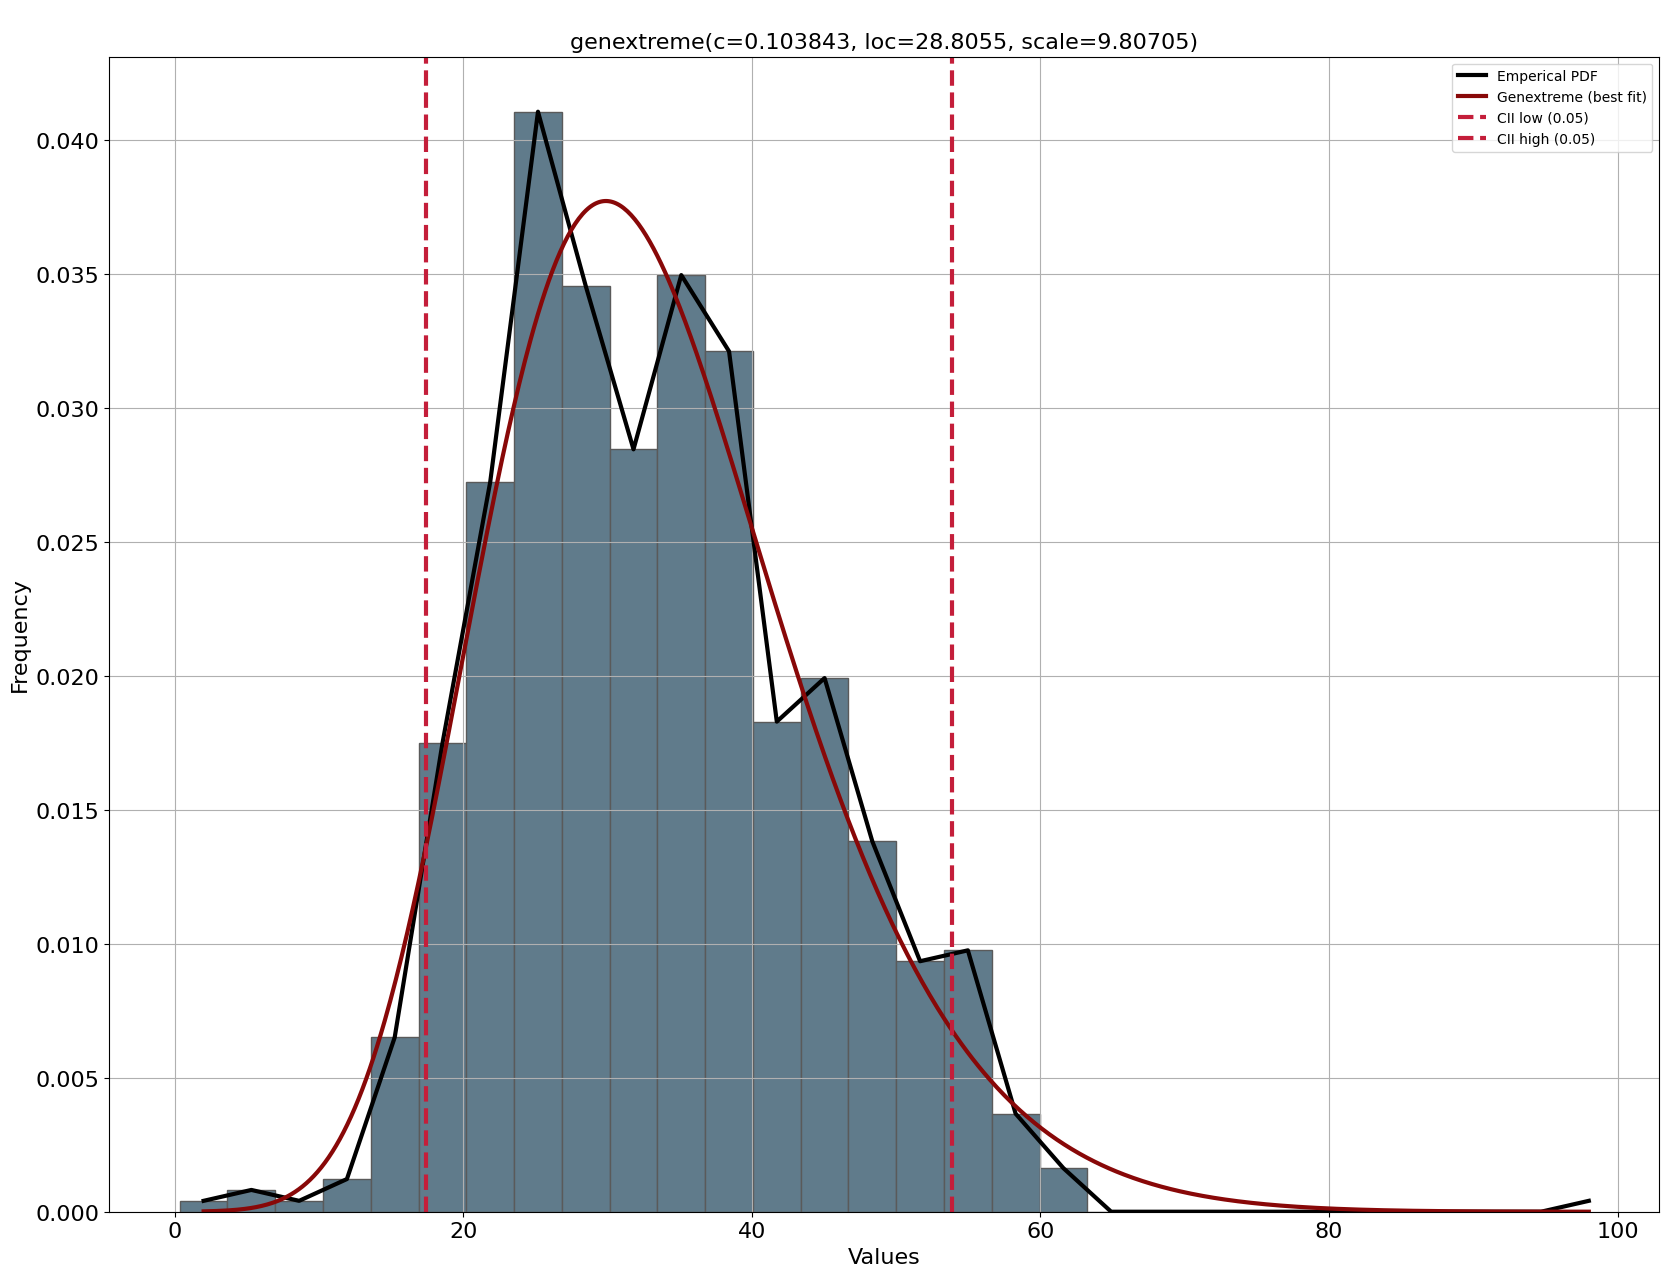

In [460]:
dist_pollution = distfit()
dist_pollution.fit_transform(df_pollution_wind["Pollution"])
dist_pollution.plot()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.117821] [loc=2.999 scale=1.426]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.181976] [loc=0.900 scale=2.099]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.181976] [loc=-134217727.100 scale=134217728.000]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 0.0806819] [loc=2.675 scale=1.226]
[distfit] >INFO> [t         ] [0.15 sec] [RSS: 0.107548] [loc=2.883 scale=1.258]
[distfit] >INFO> [genextreme] [0.03 sec] [RSS: 0.0925034] [loc=2.326 scale=1.082]
[distfit] >INFO> [gamma     ] [0.01 sec] [RSS: 0.0912084] [loc=0.615 scale=0.919]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 0.0918575] [loc=-0.306 scale=3.019]
[distfit] >INFO> [beta      ] [0.04 sec] [RSS: 0.100064] [loc=0.859 scale=7.831]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.220549] [loc=0.900 scale=6.000]
[distfit] >INFO> [loggamma  ] [0.02 sec] [RSS: 0.12003] [loc=-368.303 scale=51.776]


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\ndweibull(c=1.30344, loc=2.67506, scale=1.22572)'}, xlabel='Values', ylabel='Frequency'>)

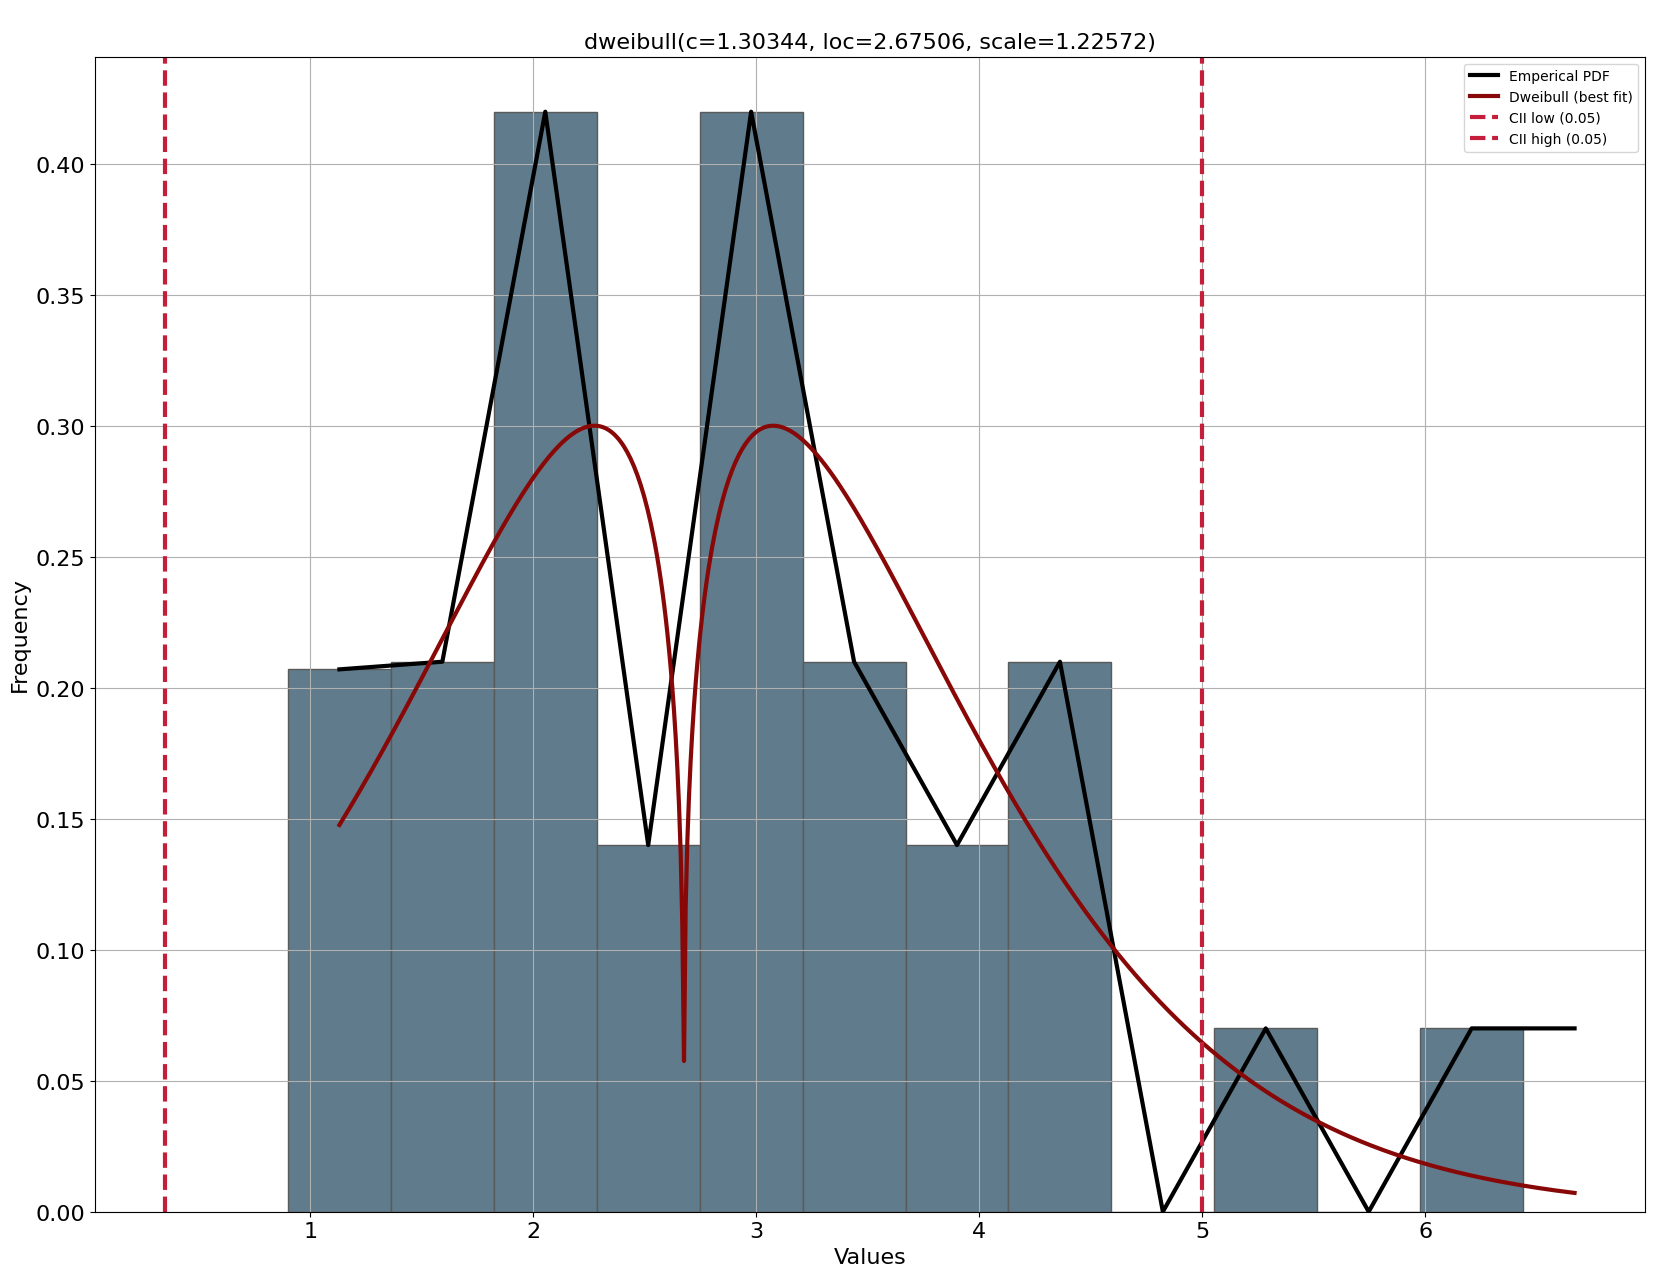

In [461]:
dist_wind= distfit()
dist_wind.fit_transform(df_pollution_wind["Wind"])
dist_wind.plot()

In [462]:
pollution_max = df_pollution_wind["Pollution"].max()
wind_max = df_pollution_wind["Wind"].max()

pollution_min = df_pollution_wind["Pollution"].min()
wind_min = df_pollution_wind["Wind"].min()

pollution_max, wind_max, pollution_min, wind_min

(99.66666666662962, 6.9, 0.33333333338735777, 0.9)

In [463]:
pollution_minimal = "pollution_minimal"
pollution_low = "pollution_low"
pollution_normal = "pollution_normal"
pollution_high = "pollution_high"
pollution_maximum = "pollution_maximum"

[0.33333333338735777, 24.916666666657406, 49.83333333331481, 74.74999999997222, 99.66666666662962]


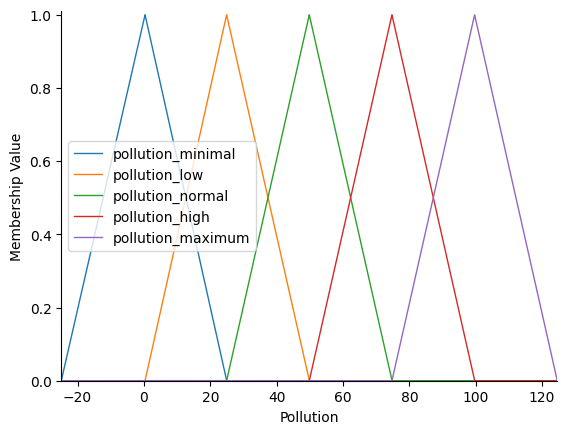

In [464]:
pollution_list = [pollution_min, pollution_max * (1/4), pollution_max * (2/4), pollution_max * (3/4), pollution_max]
print(pollution_list)

pollution = ctrl.Antecedent(np.arange(-pollution_list[1], pollution_list[4] + (pollution_list[4] - pollution_list[3]) + step_size, step_size), "pollution")
pollution[pollution_minimal] = fuzz.trimf(pollution.universe, [-pollution_list[1], pollution_list[0], pollution_list[1]])
pollution[pollution_low] = fuzz.trimf(pollution.universe, [pollution_list[0], pollution_list[1], pollution_list[2]])
pollution[pollution_normal] = fuzz.trimf(pollution.universe, [pollution_list[1], pollution_list[2], pollution_list[3]])
pollution[pollution_high] = fuzz.trimf(pollution.universe, [pollution_list[2], pollution_list[3], pollution_list[4]])
pollution[pollution_maximum] = fuzz.trimf(pollution.universe, [pollution_list[3], pollution_list[4], pollution_list[4] + (pollution_list[4] - pollution_list[3])])
pollution.view()

plt.xlabel("Pollution")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

In [465]:
wind_weak = "wind_weak"
wind_normal = "wind_normal"
wind_strong = "wind_strong"

In [466]:
# wind_list = [wind_min, wind_max * (1/2), wind_max]
# print(wind_list)

# wind = ctrl.Antecedent(np.arange(-wind_list[1], wind_list[2] + (wind_list[2] - wind_list[1]) + step_size, step_size), "wind")
# wind[wind_weak] = fuzz.trimf(wind.universe, [-wind_list[1], wind_list[0], wind_list[1]])
# wind[wind_normal] = fuzz.trimf(wind.universe, [wind_list[0], wind_list[1], wind_list[2]])
# wind[wind_strong] = fuzz.trimf(wind.universe, [wind_list[1], wind_list[2], wind_list[2] + (wind_list[2] - wind_list[1])])
# wind.view()

# plt.xlabel("Wind")
# plt.ylabel("Membership Value")
# plt.legend()
# plt.show()

[0.9, 3.45, 6.9]


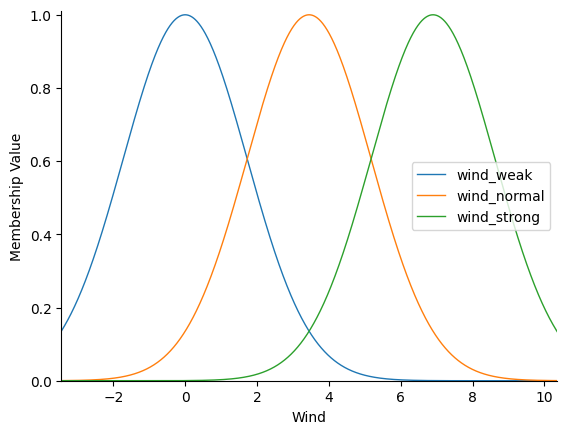

In [467]:
wind_list = [wind_min, wind_max * (1/2), wind_max]
print(wind_list)

wind = ctrl.Antecedent(np.arange(-wind_list[1], wind_list[2] + (wind_list[2] - wind_list[1]) + step_size, step_size), "wind")

params = [(0, wind_list[1]/2), (wind_list[1], wind_list[1]/2), (wind_list[2], wind_list[1]/2)]

wind[wind_weak] = fuzz.gaussmf(wind.universe, params[0][0], params[0][1])
wind[wind_normal] = fuzz.gaussmf(wind.universe, params[1][0], params[1][1])
wind[wind_strong] = fuzz.gaussmf(wind.universe, params[2][0], params[2][1])

wind.view()

plt.xlabel("Wind")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

In [468]:
# # Określ parametry dla każdej funkcji
# params = [(0, wind_list[1]/2 * 1.2),  # Zwiększ odchylenie standardowe dla wind_weak
#           (wind_list[1] - wind_list[1]/2 * 1.2, wind_list[1]*2),  # Zmniejsz odchylenie standardowe dla wind_normal
#           (wind_list[2] - wind_list[1]/2, wind_list[2])]  # Zmniejsz odchylenie standardowe dla wind_strong

# # Oblicz wartości przynależności dla wartości wejściowych
# wind[wind_weak] = fuzz.zmf(wind.universe, params[0][0], params[0][1])
# wind[wind_normal] = fuzz.zmf(wind.universe, params[1][0], params[1][1])  # Użyj funkcji typu Z dla wind_normal
# wind[wind_strong] = fuzz.smf(wind.universe, params[2][0], params[2][1])

# # Wykreśl funkcje przynależności
# wind.view()
# plt.xlabel("Wind")
# plt.ylabel("Membership Value")
# plt.legend()
# plt.show()

In [469]:

# params = [(0, wind_list[1]/2 * 1.2),
#           (wind_list[1], wind_list[1]/2 * 1.2),
#           (wind_list[2], wind_list[1]/2 * 0.8)]

# # Oblicz wartości przynależności dla wartości wejściowych
# wind[wind_weak] = fuzz.gaussmf(wind.universe, params[0][0], params[0][1])
# wind[wind_normal] = fuzz.gaussmf(wind.universe, params[1][0], params[1][1])
# wind[wind_strong] = fuzz.gaussmf(wind.universe, params[2][0], params[2][1])

# wind.view()
# plt.xlabel("Wind")
# plt.ylabel("Membership Value")
# plt.legend()
# plt.show()

In [470]:
air_quality_max = 100
air_quality_min = 0

In [471]:
air_quality_unhealthy = "air_quality_unhealthy"
air_quality_poor = "air_quality_poor"
air_quality_moderate = "air_quality_moderate"
air_quality_good = "air_quality_good"
air_quality_excelent = "air_quality_excelent"

[0, 25.0, 50.0, 75.0, 100]


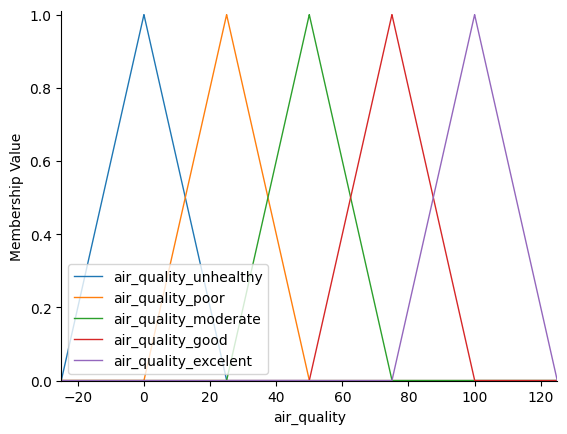

In [472]:
air_quality_list = [air_quality_min, air_quality_max * (1/4), air_quality_max * (2/4), air_quality_max * (3/4), air_quality_max]
print(air_quality_list)

air_quality = ctrl.Consequent(np.arange(-air_quality_list[1], air_quality_list[4] + (air_quality_list[4] - air_quality_list[3]) + step_size, step_size), "air_quality")
air_quality[air_quality_unhealthy] = fuzz.trimf(air_quality.universe, [-air_quality_list[1], air_quality_list[0], air_quality_list[1]])
air_quality[air_quality_poor] = fuzz.trimf(air_quality.universe, [air_quality_list[0], air_quality_list[1], air_quality_list[2]])
air_quality[air_quality_moderate] = fuzz.trimf(air_quality.universe, [air_quality_list[1], air_quality_list[2], air_quality_list[3]])
air_quality[air_quality_good] = fuzz.trimf(air_quality.universe, [air_quality_list[2], air_quality_list[3], air_quality_list[4]])
air_quality[air_quality_excelent] = fuzz.trimf(air_quality.universe, [air_quality_list[3], air_quality_list[4], air_quality_list[4] + (air_quality_list[4] - air_quality_list[3])])
air_quality.view()

plt.xlabel("air_quality")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

In [473]:
# air_quality = ctrl.Consequent(np.arange(0, 100 + step_size, step_size), "air_quality", defuzzify_method="centroid")
# air_quality[air_quality_unhealthy] = fuzz.trimf(air_quality.universe, [20, 20, 20])
# air_quality[air_quality_poor] = fuzz.trimf(air_quality.universe, [40, 40, 40])
# air_quality[air_quality_moderate] = fuzz.trimf(air_quality.universe, [60, 60, 60])
# air_quality[air_quality_good] = fuzz.trimf(air_quality.universe, [80, 80, 80])
# air_quality[air_quality_excelent] = fuzz.trimf(air_quality.universe, [100, 100, 100])
# air_quality.view()

# plt.xlabel("air_quality")
# plt.ylabel("Membership Value")
# plt.legend()
# plt.show()

In [474]:
air_quality_unhealthy = "air_quality_unhealthy"
air_quality_poor = "air_quality_poor"
air_quality_moderate = "air_quality_moderate"
air_quality_good = "air_quality_good"
air_quality_excelent = "air_quality_excelent"

wind_weak = "wind_weak"
wind_normal = "wind_normal"
wind_strong = "wind_strong"

pollution_minimal = "pollution_minimal"
pollution_low = "pollution_low"
pollution_normal = "pollution_normal"
pollution_high = "pollution_high"
pollution_maximum = "pollution_maximum"

In [475]:
rule1 = ctrl.Rule(pollution[pollution_minimal] & wind[wind_weak],  air_quality[air_quality_excelent])
rule2 = ctrl.Rule(pollution[pollution_minimal] & wind[wind_normal],  air_quality[air_quality_excelent])
rule3 = ctrl.Rule(pollution[pollution_minimal] & wind[wind_strong],  air_quality[air_quality_excelent])

rule4 = ctrl.Rule(pollution[pollution_low] & wind[wind_weak],  air_quality[air_quality_good])
rule5 = ctrl.Rule(pollution[pollution_low] & wind[wind_normal],  air_quality[air_quality_good])
rule6 = ctrl.Rule(pollution[pollution_low] & wind[wind_strong],  air_quality[air_quality_excelent])

rule7 = ctrl.Rule(pollution[pollution_normal] & wind[wind_weak],  air_quality[air_quality_moderate])
rule8 = ctrl.Rule(pollution[pollution_normal] & wind[wind_normal],  air_quality[air_quality_moderate])
rule9 = ctrl.Rule(pollution[pollution_normal] & wind[wind_strong],  air_quality[air_quality_good])

rule10 = ctrl.Rule(pollution[pollution_high] & wind[wind_weak],  air_quality[air_quality_poor])
rule11 = ctrl.Rule(pollution[pollution_high] & wind[wind_normal],  air_quality[air_quality_poor])
rule12 = ctrl.Rule(pollution[pollution_high] & wind[wind_strong],  air_quality[air_quality_moderate])

rule13 = ctrl.Rule(pollution[pollution_maximum] & wind[wind_weak],  air_quality[air_quality_unhealthy])
rule14 = ctrl.Rule(pollution[pollution_maximum] & wind[wind_normal],  air_quality[air_quality_unhealthy])
rule15 = ctrl.Rule(pollution[pollution_maximum] & wind[wind_strong],  air_quality[air_quality_unhealthy])

In [476]:
air_quality_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13, rule14, rule15])
air_quality_sim = ctrl.ControlSystemSimulation(air_quality_ctrl)

In [477]:
num_of_points = 40
pollution_values = np.linspace(pollution_min, pollution_max, num_of_points)
wind_values = np.linspace(wind_min, wind_max, num_of_points)
pollution_mesh, wind_mesh = np.meshgrid(pollution_values, wind_values)
air_quality_values = np.zeros_like(pollution_mesh)

In [478]:
def compute(defuzzify_method):
    air_quality.defuzzify_method = defuzzify_method
    for i in range(len(pollution_values)):
        for j in range(len(wind_values)):
            air_quality_sim.input["pollution"] = pollution_values[i]
            air_quality_sim.input["wind"] = wind_values[j]
            air_quality_sim.compute()
            air_quality_values[i, j] = air_quality_sim.output["air_quality"]

In [479]:
def display_3d_plot_pm_single(xlabel, ylabel, zlabel, azim):
    fig = plt.figure(figsize=(15, 15))

    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(pollution_mesh, wind_mesh, air_quality_values, cmap="RdYlGn_r")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    ax.view_init(azim=azim)

    plt.show()

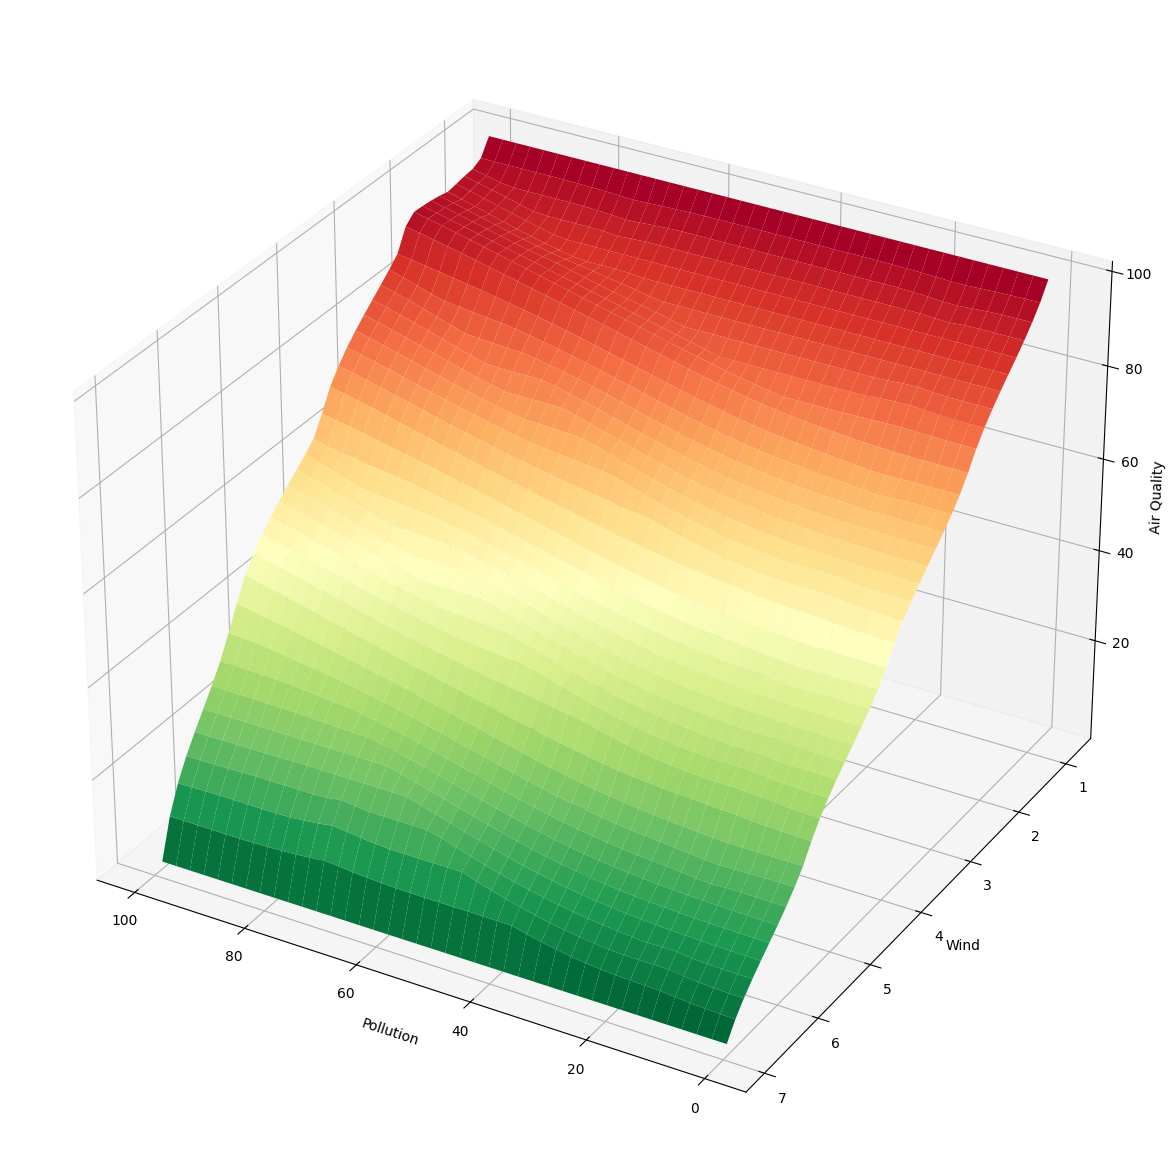

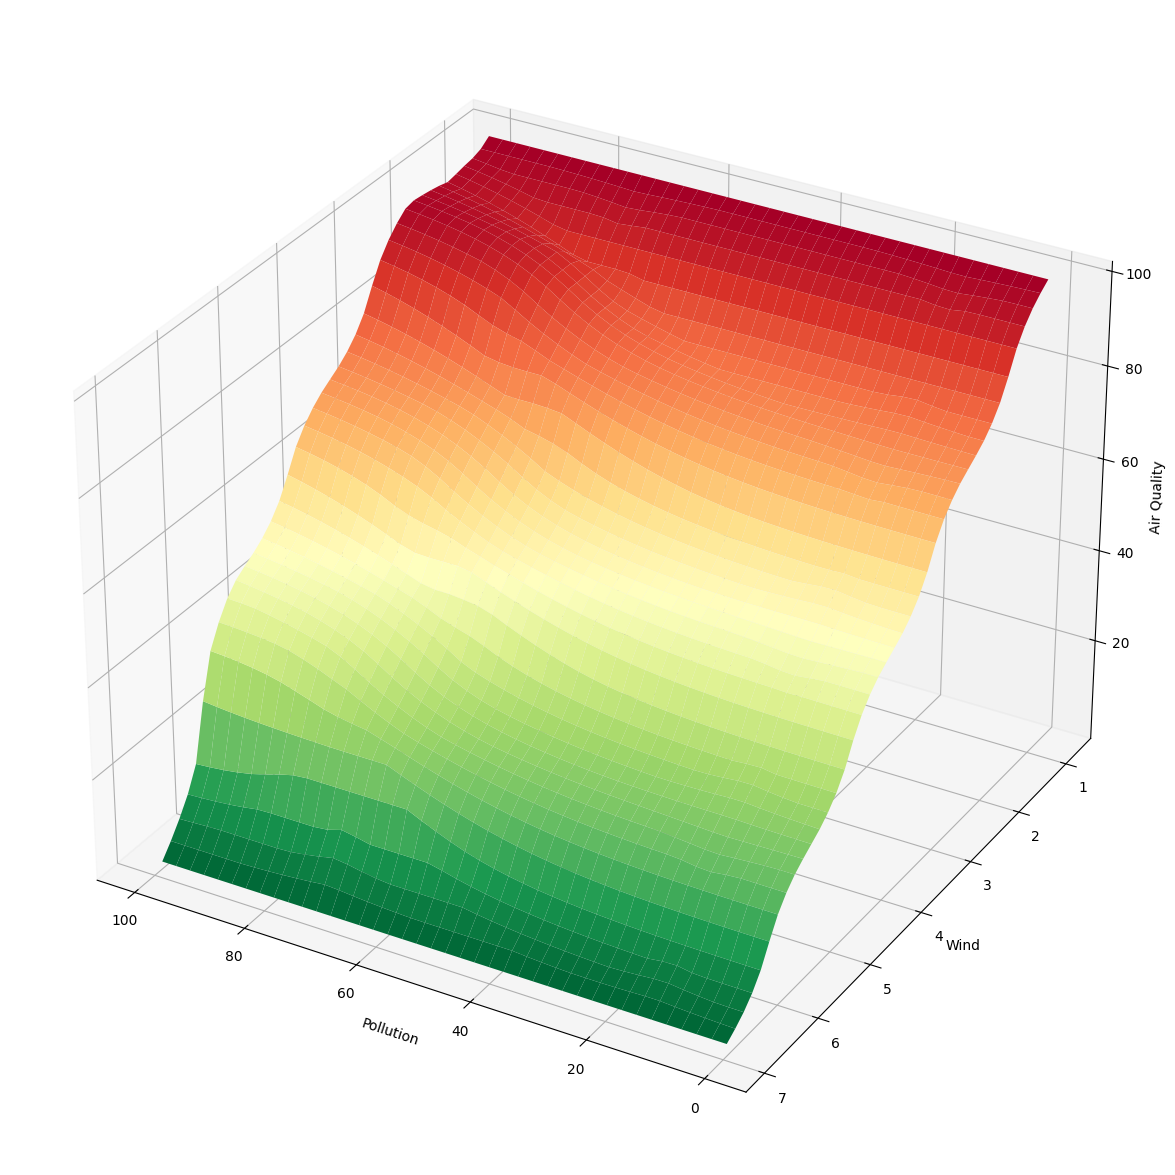

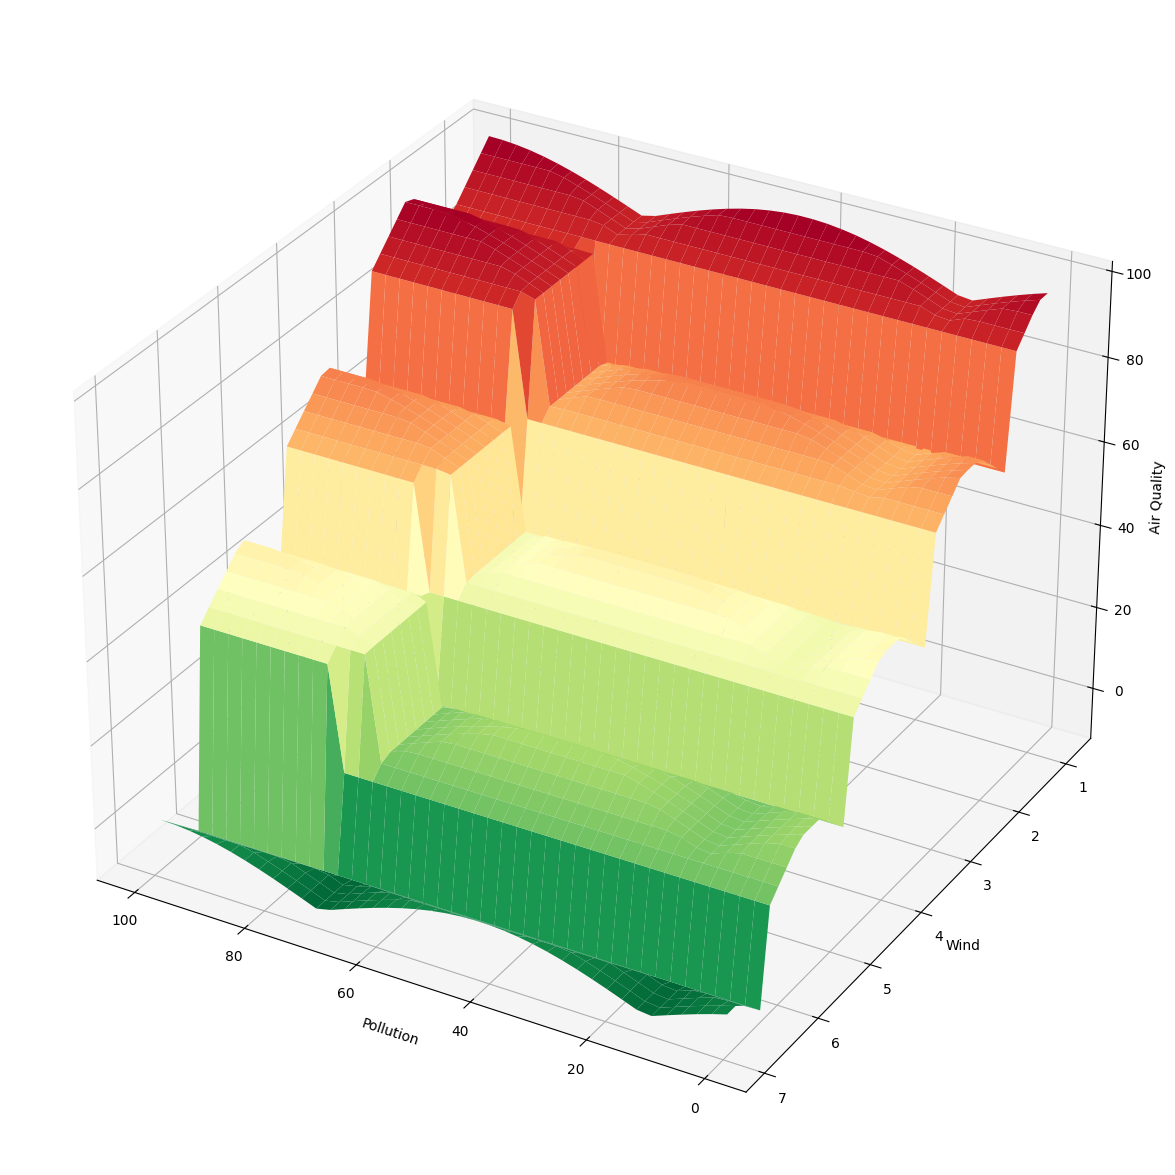

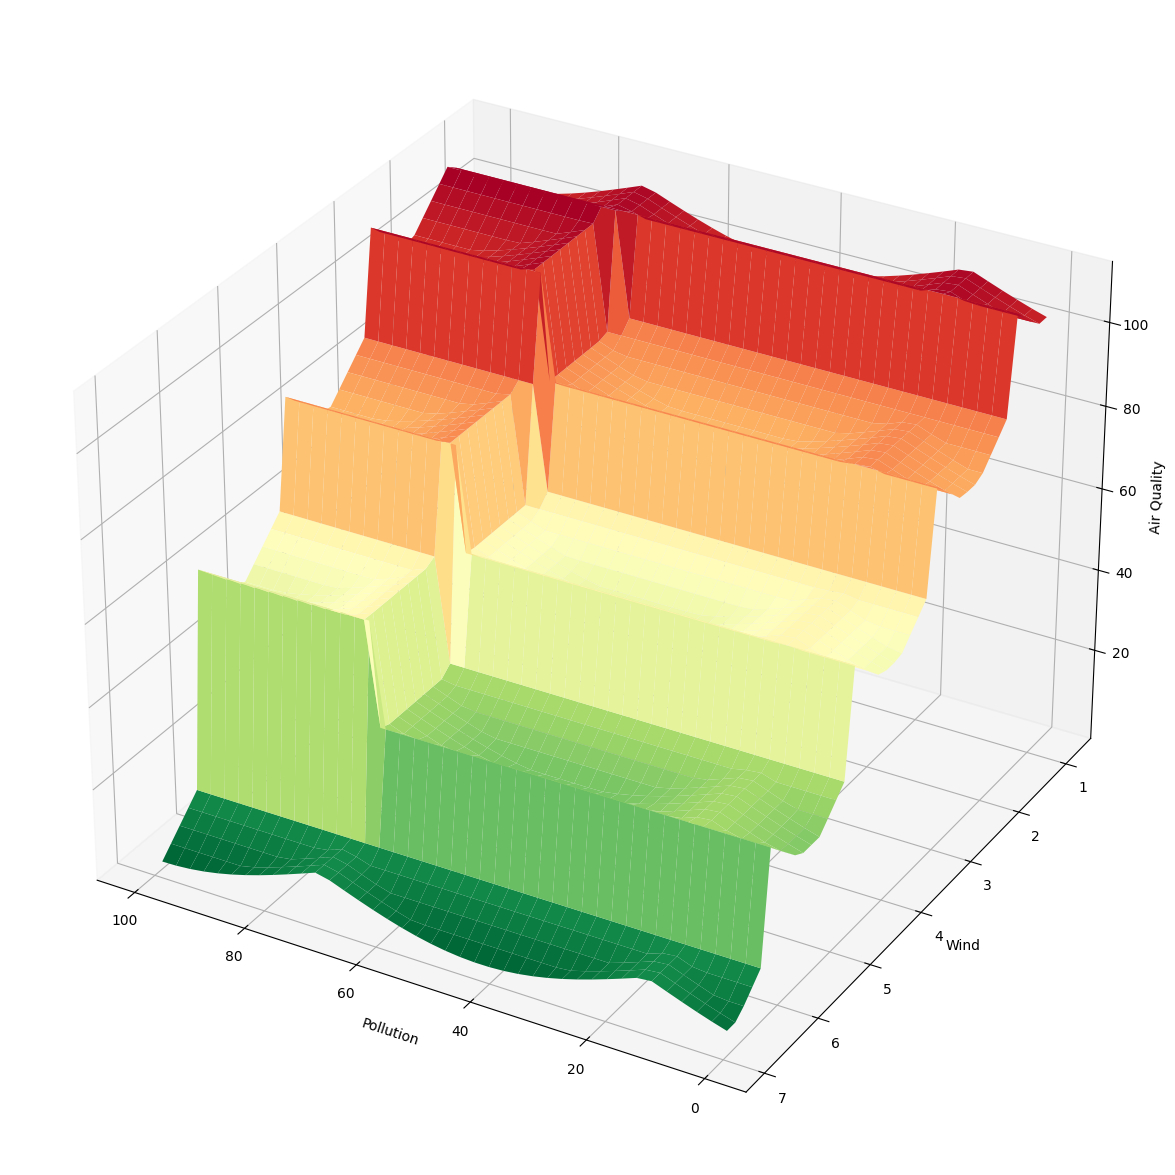

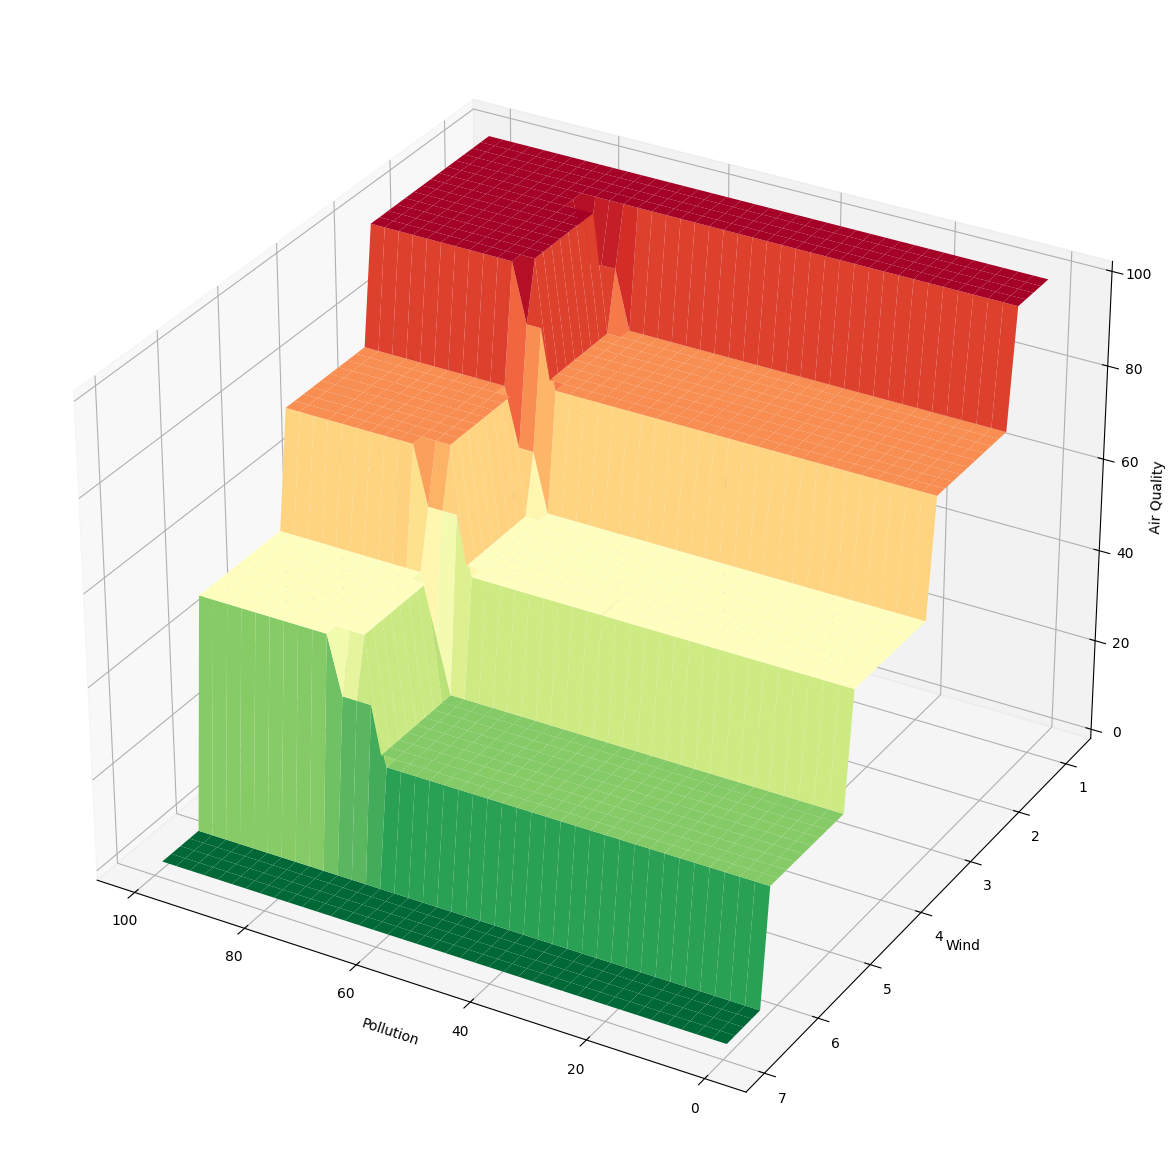

In [480]:
compute("centroid")
display_3d_plot_pm_single("Pollution", "Wind", "Air Quality", 120)

compute("bisector")
display_3d_plot_pm_single("Pollution", "Wind", "Air Quality", 120)

compute("som")
display_3d_plot_pm_single("Pollution", "Wind", "Air Quality", 120)

compute("lom")
display_3d_plot_pm_single("Pollution", "Wind", "Air Quality", 120)

compute("mom")
display_3d_plot_pm_single("Pollution", "Wind", "Air Quality", 120)